<a href="https://colab.research.google.com/github/apoorvrocks/Machine-Learning-Assignment-1/blob/main/Q5_GMM_06_APRIL_newexp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   200 classes for training.
2.   Each class has 500 images.
3.   The test set contains 10,000 images.
4.   All images are 64x64x3 colored ones.






In [ ]:
from zipfile import ZipFile
import os
import random
import numpy as np
from skimage import color, io
from skimage.transform import resize
import matplotlib.pyplot as plt
import gc
from scipy.stats import multivariate_normal
import scipy
import cv2

UNZIP DATA

In [ ]:
with ZipFile('/content/drive/MyDrive/IISc/PRNN/tiny-imagenet-200.zip', 'r') as zipObj:
   zipObj.extractall()

SET PATHS

In [ ]:
test_path = '/content/tiny-imagenet-200/test'
train_path = '/content/tiny-imagenet-200/train'
validation_path = '/content/tiny-imagenet-200/val'

In [ ]:
# x = []
# NO_CLASSES = 10
# NO_IMAGES = 50
# class_folders = os.listdir(train_path)

# # loop over classes
# for class_folder in class_folders[:NO_CLASSES]: 

#     image_folder_path = train_path + os.path.sep + class_folder + os.path.sep + 'images' + os.path.sep
#     image_file_names = os.listdir(image_folder_path)

#     # loop over images
#     for image_file_name in image_file_names[:NO_IMAGES]: # loop over all images in a class
#         img = io.imread(image_folder_path + image_file_name)
#         if len(img.shape) == 3:
#             imgGray = np.mean(img, axis=2)
#             img_resized = resize(imgGray, (10, 10))
#             flat_image = img_resized.flatten() 
            
#             x.append(flat_image)



x = []
NO_CLASSES = 10
NO_IMAGES = 100
class_folders = os.listdir(train_path)

# loop over classes
for class_folder in class_folders[:NO_CLASSES]: 

  image_folder_path = train_path + os.path.sep + class_folder + os.path.sep + 'images' + os.path.sep
  image_file_names = os.listdir(image_folder_path)

  # loop over images
  for image_file_name in image_file_names[:NO_IMAGES]: # loop over all images in a class
    img = io.imread(image_folder_path + image_file_name)
    img = cv2.resize(img, (28, 28))
    if len(img.shape) == 3:
        imgGray = 0.3*img[:,:,0] + 0.59*img[:,:,1] + 0.11*img[:,:,2]
        flat_image = imgGray.flatten() 
    else:
        flat_image = img.flatten()
    
    x.append(flat_image)


In [ ]:
# RANGE = (0, 1)
# X = normalize_matrix(np.array(x, dtype = np.float64), RANGE)
X = np.array(x) / 255

print(X.shape)
# X= np.array(x)

(1000, 784)


In [ ]:
# X = X[:500, :100]
# print(X.shape)

In [ ]:
def validate(**kwargs):
    for key, value in kwargs.items():
        if np.any(np.isnan(value)):
            raise Exception(f'--- {key} contains Nan')
        if np.any(np.isinf(value)):
            raise Exception(f'--- {key} contains Inf')

def disp_resp(a, n_clusters):
    import pandas as pd
    import numpy as np

    df_describe = pd.DataFrame(a)
    print(df_describe.describe())

    no_cols = 200
    z = a.copy()
    for col in range(a.shape[1]):
        repeats_array = np.transpose([a[:,col]] * no_cols)
        # print(repeats_array)
        z = np.hstack((z, repeats_array))
    # print(z)
    z = (z / np.max(z)) * 255
    plt.figure(figsize=(10, 10))
    im = plt.imshow(z, cmap='magma', interpolation='none')
    plt.show()

In [ ]:
class GMM:
    
    
    def __init__(self, n_features, n_clusters):
        self.clusters = {}
        self.n_clusters = n_clusters
        self.n_features = n_features
        self.eps = 1e-10

        pi = np.random.rand(n_clusters)
        self.clusters['pi'] = np.ones(n_clusters) / n_clusters
        
        print('self.clusters[pi]', self.clusters['pi'])
        self.clusters['logdet'] = np.zeros(n_clusters, dtype=np.float64)
        self.clusters['mu'] = np.random.rand(self.n_clusters, self.n_features) * 2 - 1

        inv_cov = []
        for i in range(n_clusters):
            inv_cov.append(np.eye(self.n_features))
        self.clusters['inv_cov'] = np.array(inv_cov)
        self.clusters['cov'] = np.array(inv_cov)

        print('pi shape', self.clusters['pi'].shape)
        print('mu shape', self.clusters['mu'].shape)
        print('det shape', self.clusters['logdet'].shape)
        print('inv_cov shape', self.clusters['inv_cov'].shape)


    def check_power(self, power):
        if np.max(power) >= 710:
            print(f'High Exponent Error  min:{str(np.min(power))}  max:{str(np.max(power))}  new:{str(np.max(power) - 700)}')

    
    

    def expectation_step(self, X):
        print('E step')
        # calculate responsibility for each data point, for each class
        self.resp = np.zeros((self.N, self.n_clusters), dtype=np.float64)
        self.exp = np.zeros((self.N, self.n_clusters), dtype=np.float64)
        self.log_likelihood = 0

        for k in range(self.n_clusters):
            for n in range(len(X)):
                diff = (X[n] - self.clusters['mu'][k])
                self.exp[n][k] = np.log(self.clusters['pi'][k]) - (self.clusters['logdet'][k] + np.dot(np.dot(diff.T, self.clusters['inv_cov'][k]), diff)
)/2
#                 self.exp[n][k] = np.log(self.clusters['pi'][k]) - (self.N * np.log(2 * np.pi) + self.clusters['logdet'][k] + np.dot(np.dot(diff.T, self.clusters['inv_cov'][k]), diff)
# )/2
        validate(exp_n_k = self.exp)
        validate(clusters_pi = self.clusters['pi'])
        validate(clusters_det = self.clusters['logdet'])

        for n in range(self.N):
            # self.check_power(self.exp[n])
            self.exp[n] -= (np.max(self.exp[n]) - 700)
            # print('\nself.exp[n]',self.exp[n])
            self.resp[n] = np.exp(self.exp[n], dtype=np.float64)
            # print('self.resp[n]', self.resp[n])

        validate(resp_n_k = self.resp)

        '''EQUATION 11.53'''
        for n in range(self.N):
            resp_sum = np.sum(self.resp[n])
            # print('resp_sum', resp_sum)
            self.log_likelihood += np.log(resp_sum)
            self.resp[n] = self.resp[n] / resp_sum



    def maximization_step(self, X):
        print('M step')

        N_k = np.sum(self.resp, axis=0) # get class responsibility
        print('N_k', N_k)
        for k in range(self.n_clusters):
            
            '''EQUATION 11.56'''
            # find pi for each cluster
            self.clusters['pi'][k] = N_k[k] / self.N

            '''EQUATION 11.54'''
            # find new mean for each cluster
            self.clusters['mu'][k] = np.matmul(self.resp[:, k], X) / N_k[k]

            '''EQUATION 11.55''' 
            # find covariance matrix for each cluster
            cov = np.zeros((self.n_features, self.n_features), dtype=np.float64)
            for n in range(self.N):
                v = X[n] - self.clusters['mu'][k]
                cov += self.resp[n][k] * np.outer(v, v)
            cov /= N_k[k]

            self.clusters['cov'][k] = cov
            # cov += np.random.rand(self.n_features, self.n_features) 
            dg = np.empty(self.n_features)
            dg.fill(1e-6)
            cov += np.diag(dg)
            (sign, lgdet) = np.linalg.slogdet(cov)
            self.clusters['logdet'][k] = sign * lgdet

            if not self.clusters['logdet'][k]:
                print(cov)
                raise Exception('Determinant has zero ' + str(self.clusters['logdet'][k]))

            try:
                self.clusters['inv_cov'][k] = scipy.linalg.inv(cov)
            except ValueError:
                print()
        # print('N_k', N_k)
    

    def sample(self, n_samples, cluster=None):
        probs = np.cumsum(self.clusters['pi']) 
        def get_cluster(prob):
            for i in range(self.n_clusters):
                if prob <= probs[i]:
                    return i
        samples = []
        unif = np.random.uniform(0,1,n_samples)
        for n in range(n_samples):
            k = get_cluster(unif[n])
            samples.append(np.random.default_rng().multivariate_normal(self.clusters['mu'][k], self.clusters['cov'][k]))

        return np.array(samples)

    def fit(self, X, n_epochs):

        self.N = X.shape[0]
        for i in range(n_epochs):
            self.expectation_step(X)
            self.maximization_step(X)
            print('Epoch: ', i + 1, 'log_likelihood: ', self.log_likelihood)
            disp_resp(self.resp, self.n_clusters)

        print('\n\nPI values', self.clusters['pi'])

self.clusters[pi] [0.33333333 0.33333333 0.33333333]
pi shape (3,)
mu shape (3, 784)
det shape (3,)
inv_cov shape (3, 784, 784)
E step
M step
N_k [861.91820179  40.07877126  98.00302694]
Epoch:  1 log_likelihood:  700078.9776273178
                  0             1             2
count  1.000000e+03  1.000000e+03  1.000000e+03
mean   8.619182e-01  4.007877e-02  9.800303e-02
std    2.789631e-01  1.489409e-01  2.315153e-01
min    3.447350e-07  2.612413e-13  1.575548e-11
25%    9.252931e-01  7.936342e-06  7.466361e-05
50%    9.965213e-01  1.396041e-04  1.612612e-03
75%    9.998010e-01  2.653309e-03  3.122111e-02
max    1.000000e+00  9.999965e-01  9.996833e-01


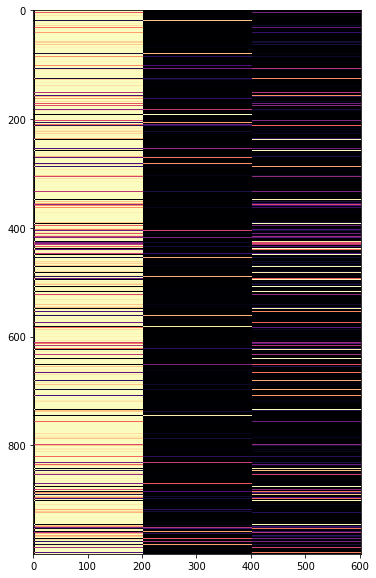

E step
M step
N_k [676.99756923 141.99999999 181.00243079]
Epoch:  2 log_likelihood:  700000.0024334737
                 0            1              2
count  1000.000000  1000.000000   1.000000e+03
mean      0.676998     0.142000   1.810024e-01
std       0.467855     0.349225   3.852097e-01
min       0.000000     0.000000   0.000000e+00
25%       0.000000     0.000000   0.000000e+00
50%       1.000000     0.000000   0.000000e+00
75%       1.000000     0.000000  4.173220e-307
max       1.000000     1.000000   1.000000e+00


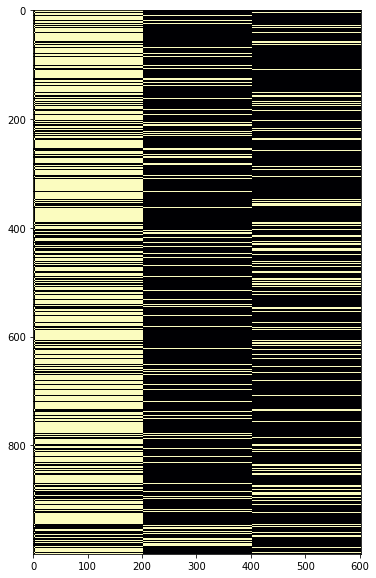

E step
M step
N_k [677. 142. 181.]
Epoch:  3 log_likelihood:  700000.0
                 0            1            2
count  1000.000000  1000.000000  1000.000000
mean      0.677000     0.142000     0.181000
std       0.467857     0.349225     0.385211
min       0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.000000
50%       1.000000     0.000000     0.000000
75%       1.000000     0.000000     0.000000
max       1.000000     1.000000     1.000000


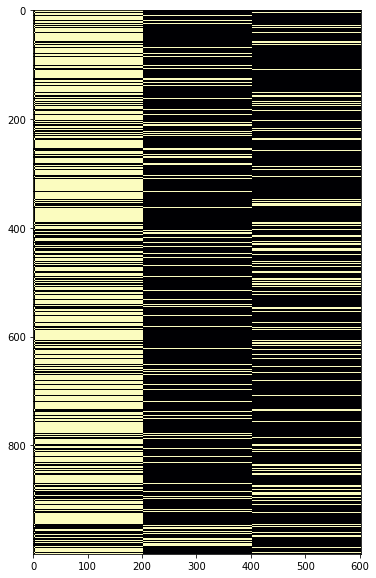



PI values [0.677 0.142 0.181]


In [ ]:
NO_CLUSTERS = 3
NO_EPOCHS = 3


gmm = GMM(X.shape[1], NO_CLUSTERS)
gmm.fit(X, NO_EPOCHS)


In [ ]:
samples = gmm.sample(1000)
print(samples.shape)

(1000, 784)


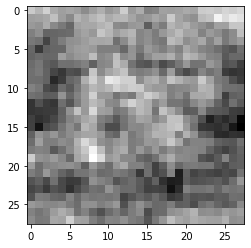

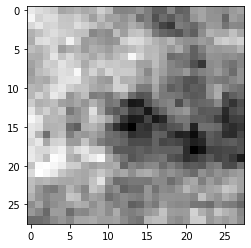

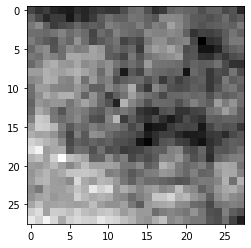

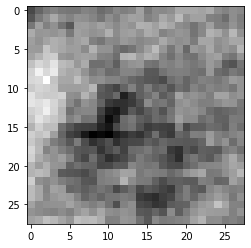

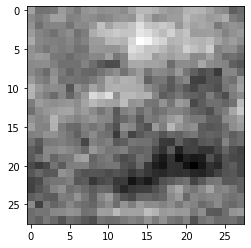

fid score: 42.453226962549195


In [ ]:
# norm_samples = samples[0]*255
len(samples), len(samples[0])
N = 5
for i in range(N):
  plt.imshow(samples[i].reshape(784, 1).reshape(28, 28),  cmap='gray')
  plt.show()

mu1, sigma1 = X.mean(axis=0), np.cov(X, rowvar=False)
mu2, sigma2 = samples[0].mean(axis=0), np.cov(samples[0],  rowvar=False)
# samples.clear



from scipy import linalg

def calculate_fid(mu1, sigma1, mu2, sigma2):
    
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # calculate sqrt of product between cov
    covmean = linalg.sqrtm(sigma1.dot(sigma2))

    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
       covmean = covmean.real

    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

fid = calculate_fid(mu1, sigma1, mu2, sigma2)
print(f'fid score: {fid}')